In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plotnine import *
import sys
from patsy import dmatrices
from mizani.formatters import percent_format
from scipy.stats import logistic
from scipy.stats import norm

In [2]:
path = Path(os.getcwd())

In [3]:
base_dir = path.parent.parent

In [4]:
data_in = os.path.join(str(base_dir) , "da_data_repo/share-health/clean/")
data_out = os.path.join(str(base_dir), "da_case_studies/ch11-smoking-health-risk/")
output = os.path.join(str(base_dir), "da_case_studies/ch12-stock-returns-risk/output/")
func = os.path.join(str(base_dir) ,   "da_case_studies/ch00-tech-prep/")

In [5]:
share = pd.read_csv(os.path.join(data_in,"share-health.csv"))

In [6]:
sys.path.append(func)

In [7]:
from py_helper_functions import *

In [8]:
#Part I

In [9]:
share.head()

,mergeid,wave,country,country_mod,int_year,int_month,female,age,eduyears_mod,sphus,br015,smoking,ever_smoked,income_pct_w4,bmi,mar_stat
0,AT-000327-01,1,11,40,2004,6,0,51.900002,-15.0,1,2,5,5,-13,32.787994,1
1,AT-000327-01,2,11,40,2007,3,0,54.700001,-3.0,5,4,5,5,-13,20.281233,1
2,AT-000327-02,1,11,40,2004,6,1,48.900002,3.0,1,3,5,5,-13,31.161373,1
3,AT-000327-02,2,11,40,2007,3,1,51.700001,3.0,2,1,5,5,-13,30.461119,1
4,AT-000674-01,4,11,40,2011,11,1,59.700001,3.0,3,1,5,5,1,24.023809,6


In [10]:
share['healthy']=0
share.loc[(share['sphus']==1) | (share['sphus']==2),'healthy']=1
share.loc[~((share['sphus']>0) & (share['sphus']<=5)),'healthy']=np.nan

In [11]:
share['healthy'].value_counts()

0.0    213847
1.0     73808
Name: healthy, dtype: int64

In [12]:
share = share.dropna(how='any')

In [13]:
share['baseline'] = 0
share.loc[share['wave']==4,'baseline']=1
share['endline'] = 0
share.loc[share['wave']==6,'endline']=1

In [14]:
share['baseline'].value_counts()

0    229773
1     57882
Name: baseline, dtype: int64

In [15]:
share['endline'].value_counts()

0    219568
1     68087
Name: endline, dtype: int64

In [16]:
share['temp'] = np.where(share['endline']==1,np.where(share['healthy']==1,1,0),np.nan)

In [17]:
share['temp'].value_counts()

0.0    51241
1.0    16846
Name: temp, dtype: int64

In [18]:
len(share)

287655

In [19]:
share.head()

,mergeid,wave,country,country_mod,int_year,int_month,female,age,eduyears_mod,sphus,br015,smoking,ever_smoked,income_pct_w4,bmi,mar_stat,healthy,baseline,endline,temp
0,AT-000327-01,1,11,40,2004,6,0,51.900002,-15.0,1,2,5,5,-13,32.787994,1,1.0,0,0,NaN
1,AT-000327-01,2,11,40,2007,3,0,54.700001,-3.0,5,4,5,5,-13,20.281233,1,0.0,0,0,NaN
2,AT-000327-02,1,11,40,2004,6,1,48.900002,3.0,1,3,5,5,-13,31.161373,1,1.0,0,0,NaN
3,AT-000327-02,2,11,40,2007,3,1,51.700001,3.0,2,1,5,5,-13,30.461119,1,1.0,0,0,NaN
4,AT-000674-01,4,11,40,2011,11,1,59.700001,3.0,3,1,5,5,1,24.023809,6,0.0,1,0,NaN


In [20]:
len(share)

287655

In [21]:
len(share['mergeid'].unique())

120147

In [22]:
#df['ratio'] = df.groupby(['a','b'], group_keys=False).apply(lambda g: g.c/(g.c * g.d).sum())


In [23]:
a=  share.groupby('mergeid').apply(lambda x:max(x.temp))

In [24]:
a.value_counts()

0.0    8597
1.0    3658
dtype: int64

In [25]:
#share['stayshealthy'].value_counts()

In [26]:
#Part 2

In [28]:
share = pd.read_csv('ch11_share.csv')

In [29]:
share.head()

,mergeid,wave,country,country_mod,int_year,int_month,female,age,sphus,br015,...,income10,bmi,mar_stat,healthy,baseline,endline,stayshealthy,exerc,married,eduyears
0,AT-001492-02,4,11,40,2011,9,0,59.799999,2,3,...,8,23.198315,1,1,1,0,1,0,1,13.0
1,AT-002136-03,4,11,40,2011,8,1,58.200001,1,2,...,9,24.801588,1,1,1,0,1,0,1,14.0
2,AT-002800-01,4,11,40,2011,9,1,57.000000,2,4,...,3,22.038567,3,1,1,0,1,0,0,23.0
3,AT-009262-02,4,11,40,2011,12,0,59.299999,2,1,...,6,25.826447,1,1,1,0,0,1,1,12.0
4,AT-009376-01,4,11,40,2011,9,0,53.299999,2,1,...,8,26.827421,1,1,1,0,0,1,1,3.0


In [30]:
lpm1 = smf.ols('stayshealthy ~ smoking', data=share).fit()

In [31]:
print(lpm1.summary())

                            OLS Regression Results                            
Dep. Variable:           stayshealthy   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     11.14
Date:                Thu, 15 Apr 2021   Prob (F-statistic):           0.000856
Time:                        10:25:07   Log-Likelihood:                -2181.2
No. Observations:                3109   AIC:                             4366.
Df Residuals:                    3107   BIC:                             4379.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6204      0.010     62.423      0.0

In [32]:
print(lpm1.get_robustcov_results(cov_type='HC1').summary())

                            OLS Regression Results                            
Dep. Variable:           stayshealthy   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     10.84
Date:                Thu, 15 Apr 2021   Prob (F-statistic):            0.00101
Time:                        10:25:17   Log-Likelihood:                -2181.2
No. Observations:                3109   AIC:                             4366.
Df Residuals:                    3107   BIC:                             4379.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6204      0.010     62.777      0.0

In [33]:
share['pred1']=lpm1.predict()

In [34]:
pd.crosstab(index = share['pred1'],columns= share['smoking'])

smoking,0,1
pred1,,
0.550287,0,696
0.620390,2413,0


In [35]:
pd.crosstab(index = share['stayshealthy'],columns= share['smoking'])

smoking,0,1
stayshealthy,,
0,916,313
1,1497,383


In [36]:
share['weight']=share.groupby(['smoking','stayshealthy'])['smoking'].transform(len)

In [37]:
share['weight_2']=share['weight']/1000

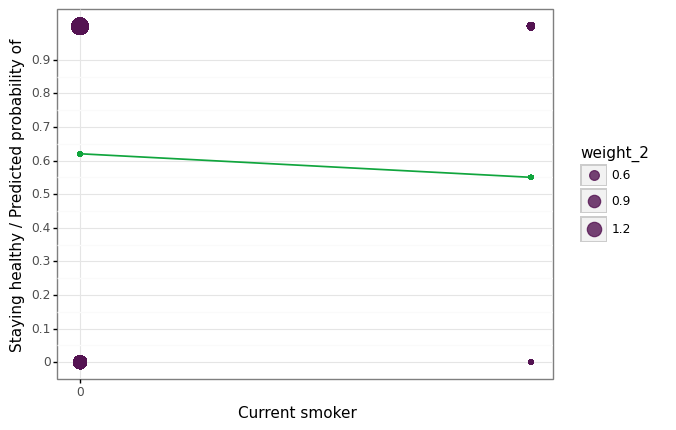

<ggplot: (326080214)>

In [38]:
g1 = (ggplot(data = share) 
 + geom_point(aes(x = 'smoking', y = 'pred1'), size = 1, color=color[1]) 
 + geom_line(aes(x = 'smoking', y = 'pred1'), colour=color[1],  size=0.7) 
 + geom_point(aes(x = 'smoking', y = 'stayshealthy', size='weight_2'), fill = color[2], color=color[2], alpha=0.8)
 + labs(x = "Current smoker",y = "Staying healthy / Predicted probability of ")
 +  coord_cartesian(xlim = [0, 1], ylim=[0,1]) 
 + scale_y_continuous(limits = [0,1], breaks = seq(0,1,0.1))
 + scale_x_continuous(limits = [0,1], breaks = seq(0,1,1))
 + theme_bw() 
)
g1

In [39]:
lpm2 = smf.ols('stayshealthy ~ smoking + ever_smoked', data=share).fit()

In [40]:
print(lpm2.get_robustcov_results(cov_type='HC1').summary())

                            OLS Regression Results                            
Dep. Variable:           stayshealthy   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.665
Date:                Thu, 15 Apr 2021   Prob (F-statistic):            0.00350
Time:                        10:25:53   Log-Likelihood:                -2181.0
No. Observations:                3109   AIC:                             4368.
Df Residuals:                    3106   BIC:                             4386.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6154      0.012     50.204      

In [41]:
share['weight']=share.groupby(['eduyears','stayshealthy'])['smoking'].transform(len)/100

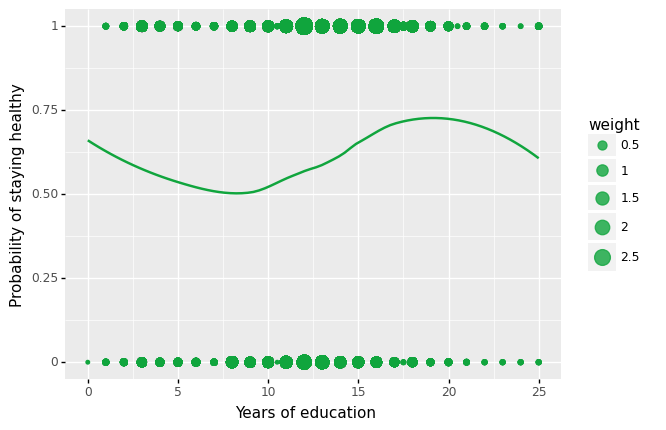

<ggplot: (326252255)>

In [42]:
g2 = (ggplot(data = share) 
 + geom_point(aes(x = 'eduyears', y = 'stayshealthy',size='weight'), color=color[1],alpha=0.8) 
 + geom_smooth(aes(x = 'eduyears', y = 'stayshealthy'),method="loess",se=False, color=color[1]) 
 + labs(x = "Years of education",y = "Probability of staying healthy ")
# + coord_cartesian(xlim = [0, 1], ylim=[0,1]) 
# + scale_x_continuous(expand = [0.01,0.01], limits = [0,25], breaks = seq(0,25,4))
# + scale_y_continuous(expand = [0.01,0.01], limits = [0,1], breaks = seq(0,1,0.1))
# + theme_bw() 
)
g2

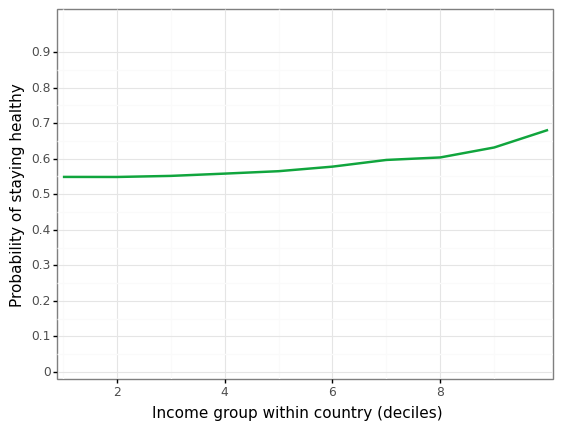

<ggplot: (286372416)>

In [43]:
g2b = (ggplot(data = share) 
 + geom_smooth(aes(x = 'income10', y = 'stayshealthy'),method="loess",se=False, color=color[1]) 
 + labs(x = "Income group within country (deciles)",y = "Probability of staying healthy ")
 + scale_x_continuous(expand = [0.01,0.01], limits = [1,10], breaks = seq(0,10,2))
 + scale_y_continuous(expand = [0.01,0.01], limits = [0,1], breaks = seq(0,1,0.1))
 + theme_bw() 
)
g2b

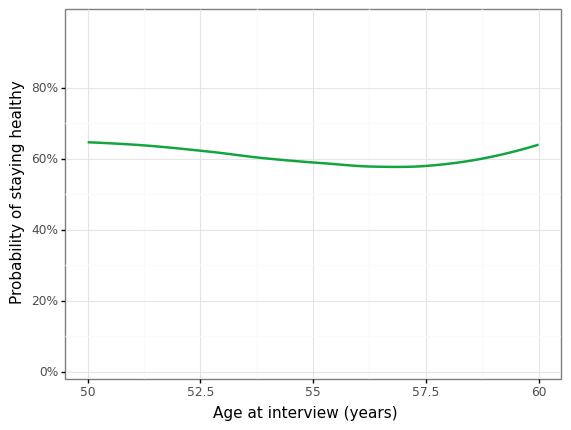

<ggplot: (332539721)>

In [44]:
g2c = (ggplot(data = share)
  + geom_smooth(aes(x='age', y='stayshealthy'), method="loess",se=False ,color=color[1])
  + scale_y_continuous(expand = [0.01,0.01],limits = [0,1], breaks = seq(0,1,0.2), labels =percent_format()) 
  + labs(x = "Age at interview (years)",y = "Probability of staying healthy") 
  + theme_bw() 
)
g2c

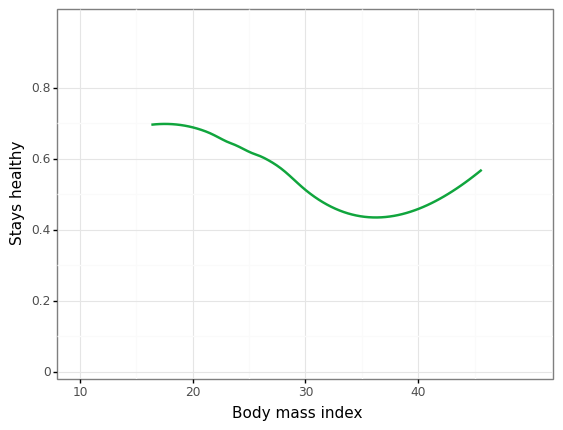

<ggplot: (325930740)>

In [45]:
g2d = (ggplot(data = share)
  + geom_smooth(aes(x='bmi', y='stayshealthy'), method="loess",se=False ,color=color[1])
  + scale_y_continuous(expand = [0.01,0.01],limits = [0,1], breaks = seq(0,1,0.2)) 
  + scale_x_continuous(limits = [10,50], breaks = seq(10,50, 10))
  + labs(x = "Body mass index",y = "Stays healthy")
  + theme_bw() 
)
g2d

In [46]:
#Part 3

In [47]:
share['country'] = share['country'].astype('category')

In [48]:
y,X = dmatrices("stayshealthy ~ smoking + ever_smoked + female + age + lspline(eduyears,[8,18]) + \
                 income10 + lspline(bmi,[35]) + exerc + country",share)

In [49]:
lpm3 = sm.OLS(y, X)
lpm3 = lpm3.fit()

In [50]:
print(lpm3.get_robustcov_results(cov_type='HC1').summary())

                            OLS Regression Results                            
Dep. Variable:           stayshealthy   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     17.32
Date:                Thu, 15 Apr 2021   Prob (F-statistic):           4.57e-68
Time:                        10:26:52   Log-Likelihood:                -2018.4
No. Observations:                3109   AIC:                             4087.
Df Residuals:                    3084   BIC:                             4238.
Df Model:                          24                                         
Covariance Type:                  HC1                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [51]:
share['pred_lpm'] = lpm3.predict()

In [52]:
share['pred_lpm'].describe()

count    3109.000000
mean        0.604696
std         0.156665
min         0.036103
25%         0.500122
50%         0.607342
75%         0.713423
max         1.011026
Name: pred_lpm, dtype: float64

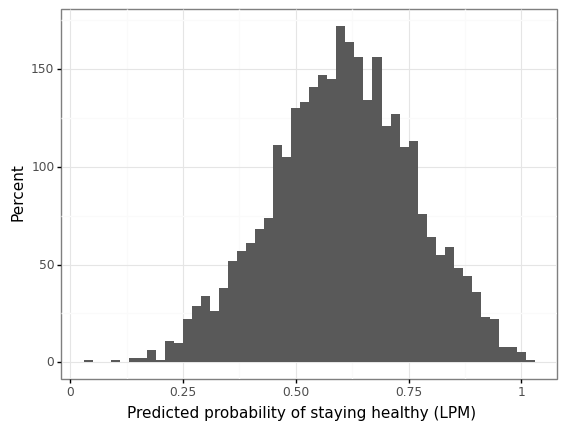

<ggplot: (332619505)>

In [53]:
g3 = (ggplot(data = share)
  + geom_histogram(aes(x='pred_lpm'),binwidth=0.02)
  + labs(x = "Predicted probability of staying healthy (LPM)",y = "Percent")
  #+ scale_y_continuous(expand = [0.00,0.0], limits = [0,0.07], breaks = seq(0, 0.07, 0.01)) 
 # + scale_x_continuous(expand = [0.001,0.01], limits = [0,1.1], breaks = seq(0,1.1, 0.2)) 
  + theme_bw() 
)
g3

In [54]:
share['pred_lpm'].head()

0    0.654021
1    0.696147
2    0.749901
3    0.703965
4    0.598621
Name: pred_lpm, dtype: float64

In [55]:
share['pred_lpm'].tail()

3104    0.524138
3105    0.622032
3106    0.517906
3107    0.508623
3108    0.522271
Name: pred_lpm, dtype: float64

In [56]:
share['pred_lpm'].values

array([0.6540205 , 0.69614673, 0.74990148, ..., 0.51790601, 0.50862266,
       0.52227106])

In [57]:
a = pd.qcut(share['pred_lpm'], 100, labels=False)

In [58]:
a

0       61
1       71
2       81
3       72
4       47
        ..
3104    30
3105    53
3106    28
3107    26
3108    29
Name: pred_lpm, Length: 3109, dtype: int64

In [61]:
cuts = 100
share['q100_pred_lpm']=pd.qcut(share['pred_lpm'],q=cuts, labels=range(1, cuts+1))

In [62]:
share.loc[share['q100_pred_lpm']==1,['smoking','ever_smoked','female','age','eduyears','income10','bmi','exerc']].describe() 

,smoking,ever_smoked,female,age,eduyears,income10,bmi,exerc
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,0.375000,0.468750,0.375000,56.025000,7.656250,3.781250,30.546116,0.187500
std,0.491869,0.507007,0.491869,2.635612,3.278566,2.825396,3.888588,0.396558
min,0.000000,0.000000,0.000000,50.400002,0.000000,1.000000,23.046875,0.000000
25%,0.000000,0.000000,0.000000,53.875001,4.750000,1.000000,28.074772,0.000000
50%,0.000000,0.000000,0.000000,56.450001,8.000000,3.000000,30.484055,0.000000
75%,1.000000,1.000000,1.000000,57.849999,10.250000,6.250000,33.924048,0.000000
max,1.000000,1.000000,1.000000,59.900002,14.000000,10.000000,38.062283,1.000000


In [63]:
share.loc[share['q100_pred_lpm']==100,['smoking','ever_smoked','female','age','eduyears','income10','bmi','exerc']].describe()

,smoking,ever_smoked,female,age,eduyears,income10,bmi,exerc
count,32.0,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,0.0,0.406250,0.968750,53.859375,17.296875,8.937500,20.803103,0.906250
std,0.0,0.498991,0.176777,2.478926,1.512632,1.644885,1.804429,0.296145
min,0.0,0.000000,0.000000,50.599998,13.000000,4.000000,17.156261,0.000000
25%,0.0,0.000000,1.000000,52.099998,16.000000,8.750000,19.664116,1.000000
50%,0.0,0.000000,1.000000,53.400000,17.500000,10.000000,20.848943,1.000000
75%,0.0,1.000000,1.000000,55.225000,18.000000,10.000000,22.108938,1.000000
max,0.0,1.000000,1.000000,60.000000,20.000000,10.000000,24.508945,1.000000


In [64]:
#Part 4

In [65]:
logit = sm.GLM(y,X, family=sm.families.Binomial(link=sm.genmod.families.links.logit()))

In [66]:
logit = sm.GLM(y,X, family=sm.families.Binomial(link=sm.genmod.families.links.logit()))
logit = logit.fit()

In [67]:
logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                            GLM   Df Residuals:                     3084
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1918.8
Date:                Thu, 15 Apr 2021   Deviance:                       3837.5
Time:                        10:28:33   Pearson chi2:                 3.12e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.2781      0.885      2.573      0.010       0.543       4.013
country[T.12]                    -0.9828      0.330     -2.978      0.003      -1.630      -0.336
country[T.13]                    -0.1972      0.276     -0.714      0.475      -0.739       0.344
country[T.15]                    -0.6560      0.194     -3.382      0.001      -1.036      -0.276
country[T.16]                    -1.1196      0.185     -6.051      0.000      -1.482      -0.757
country[T.17]                    -0.7850      0.169     -4.640      0.000      -1.116      -0.453
country[T.18]                     0.4358      0.181      2.411      0.016       0.082       0.790
country[T.20]                     0.0679      0.159      0.426      0.670      -0.244       0.380
country[T.23]                    -0.5734      0.157     -3.650      0.000      -0.881      -0.265
country[T.28]                    -0.7552      0.176     -4.297      0.000      -1.100      -0.411
country[T.29]                    -1.4707      0.395     -3.719      0.000      -2.246      -0.696
country[T.33]                    -1.5783      0.301     -5.243      0.000      -2.168      -0.988
country[T.34]                    -0.9203      0.205     -4.482      0.000      -1.323      -0.518
country[T.35]                    -1.3535      0.211     -6.416      0.000      -1.767      -0.940
smoking                          -0.2840      0.109     -2.601      0.009      -0.498      -0.070
ever_smoked                       0.0782      0.092      0.849      0.396      -0.102       0.259
female                            0.1608      0.082      1.964      0.050       0.000       0.321
age                              -0.0123      0.014     -0.859      0.391      -0.040       0.016
lspline(eduyears, [8, 18])[0]    -0.0030      0.033     -0.090      0.928      -0.068       0.062
lspline(eduyears, [8, 18])[1]     0.0791      0.016      5.022      0.000       0.048       0.110
lspline(eduyears, [8, 18])[2]    -0.0457      0.055     -0.825      0.410      -0.154       0.063
income10                          0.0356      0.015      2.452      0.014       0.007       0.064
lspline(bmi, [35])[0]            -0.0575      0.011     -5.033      0.000      -0.080      -0.035
lspline(bmi, [35])[1]             0.0311      0.071      0.439      0.661      -0.108       0.170
exerc                             0.2548      0.079      3.229      0.001       0.100       0.410
=================================================================================================
"""

In [68]:
share['pred_logit'] = logit.predict()

In [69]:
share['pred_logit'].describe()

count    3109.000000
mean        0.604696
std         0.157277
min         0.107760
25%         0.496971
50%         0.614335
75%         0.723092
max         0.920142
Name: pred_logit, dtype: float64

In [70]:
logit = sm.Logit(y,X)

In [71]:
type(logit)

statsmodels.discrete.discrete_model.Logit

In [72]:
logit_result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.617166
         Iterations 5


In [73]:
logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                          Logit   Df Residuals:                     3084
Method:                           MLE   Df Model:                           24
Date:                Thu, 15 Apr 2021   Pseudo R-squ.:                 0.08031
Time:                        10:28:49   Log-Likelihood:                -1918.8
converged:                       True   LL-Null:                       -2086.3
Covariance Type:            nonrobust   LLR p-value:                 1.329e-56
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.2781      0.885      2.573      0.010       0.543       4.013
country[T.12]                    -0.9828      0.330     -2.978      0.003      -1.630      -0.336
country[T.13]                    -0.1972      0.276     -0.714      0.475      -0.739       0.344
country[T.15]                    -0.6560      0.194     -3.382      0.001      -1.036      -0.276
country[T.16]                    -1.1196      0.185     -6.051      0.000      -1.482      -0.757
country[T.17]                    -0.7850      0.169     -4.640      0.000      -1.116      -0.453
country[T.18]                     0.4358      0.181      2.411      0.016       0.082       0.790
country[T.20]                     0.0679      0.159      0.426      0.670      -0.244       0.380
country[T.23]                    -0.5734      0.157     -3.650      0.000      -0.881      -0.265
country[T.28]                    -0.7552      0.176     -4.297      0.000      -1.100      -0.411
country[T.29]                    -1.4707      0.395     -3.719      0.000      -2.246      -0.696
country[T.33]                    -1.5783      0.301     -5.243      0.000      -2.168      -0.988
country[T.34]                    -0.9203      0.205     -4.482      0.000      -1.323      -0.518
country[T.35]                    -1.3535      0.211     -6.416      0.000      -1.767      -0.940
smoking                          -0.2840      0.109     -2.601      0.009      -0.498      -0.070
ever_smoked                       0.0782      0.092      0.849      0.396      -0.102       0.259
female                            0.1608      0.082      1.964      0.050       0.000       0.321
age                              -0.0123      0.014     -0.859      0.391      -0.040       0.016
lspline(eduyears, [8, 18])[0]    -0.0030      0.033     -0.090      0.928      -0.068       0.062
lspline(eduyears, [8, 18])[1]     0.0791      0.016      5.022      0.000       0.048       0.110
lspline(eduyears, [8, 18])[2]    -0.0457      0.055     -0.825      0.410      -0.154       0.063
income10                          0.0356      0.015      2.452      0.014       0.007       0.064
lspline(bmi, [35])[0]            -0.0575      0.011     -5.033      0.000      -0.080      -0.035
lspline(bmi, [35])[1]             0.0311      0.071      0.439      0.661      -0.108       0.170
exerc                             0.2548      0.079      3.229      0.001       0.100       0.410
=================================================================================================
"""

In [74]:
logit_margef_results = logit_result.get_margeff()

In [75]:
logit_margef_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:           stayshealthy
Method:                          dydx
At:                           overall
=================================================================================================
                                   dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
country[T.12]                    -0.2106      0.070     -2.993      0.003      -0.349      -0.073
country[T.13]                    -0.0423      0.059     -0.714      0.475      -0.158       0.074
country[T.15]                    -0.1406      0.041     -3.406      0.001      -0.221      -0.060
country[T.16]                    -0.2399      0.039     -6.191      0.000      -0.316      -0.164
country[T.17]                    -0.1682      0.036     -4.701      0.000      -0.238      -0.098
country[T.18]                     0.0934      0.039      2.417      0.016       0.018       0.169
country[T.20]                     0.0146      0.034      0.427      0.670      -0.052       0.081
country[T.23]                    -0.1229      0.033     -3.678      0.000      -0.188      -0.057
country[T.28]                    -0.1618      0.037     -4.345      0.000      -0.235      -0.089
country[T.29]                    -0.3152      0.084     -3.751      0.000      -0.480      -0.150
country[T.33]                    -0.3382      0.063     -5.332      0.000      -0.463      -0.214
country[T.34]                    -0.1972      0.043     -4.538      0.000      -0.282      -0.112
country[T.35]                    -0.2901      0.044     -6.582      0.000      -0.376      -0.204
smoking                          -0.0609      0.023     -2.611      0.009      -0.107      -0.015
ever_smoked                       0.0168      0.020      0.849      0.396      -0.022       0.055
female                            0.0345      0.018      1.968      0.049       0.000       0.069
age                              -0.0026      0.003     -0.859      0.390      -0.009       0.003
lspline(eduyears, [8, 18])[0]    -0.0006      0.007     -0.090      0.928      -0.015       0.013
lspline(eduyears, [8, 18])[1]     0.0170      0.003      5.097      0.000       0.010       0.023
lspline(eduyears, [8, 18])[2]    -0.0098      0.012     -0.825      0.409      -0.033       0.013
income10                          0.0076      0.003      2.461      0.014       0.002       0.014
lspline(bmi, [35])[0]            -0.0123      0.002     -5.109      0.000      -0.017      -0.008
lspline(bmi, [35])[1]             0.0067      0.015      0.439      0.661      -0.023       0.036
exerc                             0.0546      0.017      3.248      0.001       0.022       0.088
=================================================================================================
"""

In [76]:
probit = sm.Probit(y,X)

In [77]:
probit_result = probit.fit()

Optimization terminated successfully.
         Current function value: 0.617255
         Iterations 5


In [78]:
probit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                         Probit   Df Residuals:                     3084
Method:                           MLE   Df Model:                           24
Date:                Thu, 15 Apr 2021   Pseudo R-squ.:                 0.08018
Time:                        10:28:53   Log-Likelihood:                -1919.0
converged:                       True   LL-Null:                       -2086.3
Covariance Type:            nonrobust   LLR p-value:                 1.722e-56
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.4340      0.540      2.656      0.008       0.376       2.492
country[T.12]                    -0.5952      0.203     -2.926      0.003      -0.994      -0.197
country[T.13]                    -0.1128      0.166     -0.678      0.498      -0.439       0.213
country[T.15]                    -0.4007      0.119     -3.368      0.001      -0.634      -0.167
country[T.16]                    -0.6872      0.113     -6.082      0.000      -0.909      -0.466
country[T.17]                    -0.4761      0.103     -4.615      0.000      -0.678      -0.274
country[T.18]                     0.2573      0.105      2.440      0.015       0.051       0.464
country[T.20]                     0.0425      0.096      0.445      0.657      -0.145       0.230
country[T.23]                    -0.3450      0.095     -3.622      0.000      -0.532      -0.158
country[T.28]                    -0.4579      0.108     -4.252      0.000      -0.669      -0.247
country[T.29]                    -0.8784      0.235     -3.740      0.000      -1.339      -0.418
country[T.33]                    -0.9741      0.182     -5.359      0.000      -1.330      -0.618
country[T.34]                    -0.5592      0.126     -4.426      0.000      -0.807      -0.312
country[T.35]                    -0.8280      0.129     -6.407      0.000      -1.081      -0.575
smoking                          -0.1705      0.066     -2.568      0.010      -0.301      -0.040
ever_smoked                       0.0443      0.056      0.793      0.428      -0.065       0.154
female                            0.0973      0.050      1.953      0.051      -0.000       0.195
age                              -0.0083      0.009     -0.955      0.339      -0.025       0.009
lspline(eduyears, [8, 18])[0]    -0.0021      0.020     -0.102      0.918      -0.041       0.037
lspline(eduyears, [8, 18])[1]     0.0478      0.010      5.015      0.000       0.029       0.066
lspline(eduyears, [8, 18])[2]    -0.0286      0.033     -0.864      0.388      -0.093       0.036
income10                          0.0216      0.009      2.446      0.014       0.004       0.039
lspline(bmi, [35])[0]            -0.0346      0.007     -5.002      0.000      -0.048      -0.021
lspline(bmi, [35])[1]             0.0169      0.044      0.388      0.698      -0.069       0.102
exerc                             0.1510      0.048      3.148      0.002       0.057       0.245
=================================================================================================
"""

In [79]:
share['pred_probit']=probit_result.predict()

In [80]:
share['pred_probit'].describe()

count    3109.000000
mean        0.604763
std         0.156611
min         0.103114
25%         0.498824
50%         0.612903
75%         0.720459
max         0.930006
Name: pred_probit, dtype: float64

In [81]:
probit_margef_results = probit_result.get_margeff()

In [82]:
probit_margef_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:           stayshealthy
Method:                          dydx
At:                           overall
=================================================================================================
                                   dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
country[T.12]                    -0.2096      0.071     -2.938      0.003      -0.349      -0.070
country[T.13]                    -0.0397      0.059     -0.678      0.498      -0.155       0.075
country[T.15]                    -0.1411      0.042     -3.386      0.001      -0.223      -0.059
country[T.16]                    -0.2420      0.039     -6.193      0.000      -0.319      -0.165
country[T.17]                    -0.1677      0.036     -4.662      0.000      -0.238      -0.097
country[T.18]                     0.0906      0.037      2.446      0.014       0.018       0.163
country[T.20]                     0.0150      0.034      0.445      0.656      -0.051       0.081
country[T.23]                    -0.1215      0.033     -3.643      0.000      -0.187      -0.056
country[T.28]                    -0.1613      0.038     -4.288      0.000      -0.235      -0.088
country[T.29]                    -0.3094      0.082     -3.764      0.000      -0.470      -0.148
country[T.33]                    -0.3430      0.063     -5.435      0.000      -0.467      -0.219
country[T.34]                    -0.1969      0.044     -4.468      0.000      -0.283      -0.111
country[T.35]                    -0.2916      0.045     -6.536      0.000      -0.379      -0.204
smoking                          -0.0601      0.023     -2.575      0.010      -0.106      -0.014
ever_smoked                       0.0156      0.020      0.793      0.428      -0.023       0.054
female                            0.0343      0.018      1.957      0.050   -5.49e-05       0.069
age                              -0.0029      0.003     -0.956      0.339      -0.009       0.003
lspline(eduyears, [8, 18])[0]    -0.0007      0.007     -0.102      0.918      -0.015       0.013
lspline(eduyears, [8, 18])[1]     0.0168      0.003      5.074      0.000       0.010       0.023
lspline(eduyears, [8, 18])[2]    -0.0101      0.012     -0.864      0.387      -0.033       0.013
income10                          0.0076      0.003      2.453      0.014       0.002       0.014
lspline(bmi, [35])[0]            -0.0122      0.002     -5.060      0.000      -0.017      -0.007
lspline(bmi, [35])[1]             0.0060      0.015      0.388      0.698      -0.024       0.036
exerc                             0.0532      0.017      3.161      0.002       0.020       0.086
=================================================================================================
"""

In [83]:
df_plot = pd.melt(share[['pred_lpm','pred_logit','pred_probit']].rename(
        columns={'pred_logit':'Logit','pred_probit':'Probit'}),
        value_vars=['Logit','Probit'],id_vars=['pred_lpm'])

In [84]:
df_plot

,pred_lpm,variable,value
0,0.654021,Logit,0.659110
1,0.696147,Logit,0.703133
2,0.749901,Logit,0.753263
3,0.703965,Logit,0.711565
4,0.598621,Logit,0.599850
...,...,...,...
6213,0.524138,Probit,0.526791
6214,0.622032,Probit,0.636042
6215,0.517906,Probit,0.523045
6216,0.508623,Probit,0.508890


/usr/local/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 4 rows containing missing values.


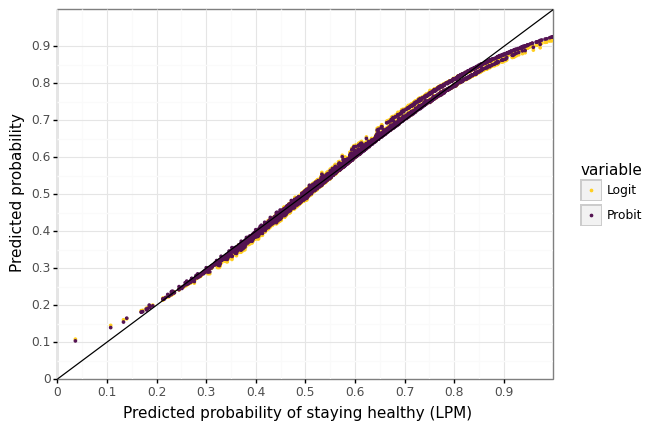

<ggplot: (332635152)>

In [85]:
g5 = (ggplot(data = df_plot) 
  + geom_point(aes(x='pred_lpm', y='value',color='variable'), size=0.5)
  + geom_abline(intercept = 0, slope = 1)    
  #+ geom_line(aes(x='pred_lpm',y='pred_lpm'),    color=color[1], size=0.4)    
  + labs(x = "Predicted probability of staying healthy (LPM)", y="Predicted probability")
  + scale_y_continuous(expand = [0.00,0.0], limits = [0,1], breaks = seq(0,1,0.1)) 
  + scale_x_continuous(expand = [0.00,0.0], limits = [0,1], breaks = seq(0,1,0.1))
  + scale_color_manual(name = "", values=[color[3],color[2], color[1]])     
  + theme_bw()    
  #+ theme_bw()
  #+ theme_bg()+
)
g5

In [86]:
#Part 5 goodness of fit

In [87]:
lpmbase = smf.ols('stayshealthy ~ smoking', data=share).fit()

In [88]:
share['pred_lpmbase']=lpmbase.predict()

In [89]:
share['stayshealthy']

0       1
1       1
2       1
3       0
4       0
       ..
3104    1
3105    1
3106    1
3107    1
3108    0
Name: stayshealthy, Length: 3109, dtype: int64

In [90]:
share[share['stayshealthy']==1]

,mergeid,wave,country,country_mod,int_year,int_month,female,age,sphus,br015,...,married,eduyears,pred1,weight,weight_2,pred_lpm,q100_pred_lpm,pred_logit,pred_probit,pred_lpmbase
0,AT-001492-02,4,11,40,2011,9,0,59.799999,2,3,...,1,13.0,0.550287,1.56,0.383,0.654021,62,0.659110,0.655557,0.550287
1,AT-002136-03,4,11,40,2011,8,1,58.200001,1,2,...,1,14.0,0.550287,1.59,0.383,0.696147,72,0.703133,0.700137,0.550287
2,AT-002800-01,4,11,40,2011,9,1,57.000000,2,4,...,0,23.0,0.620390,0.05,1.497,0.749901,82,0.753263,0.750372,0.620390
5,AT-011070-01,4,11,40,2011,9,1,58.900002,2,1,...,1,14.0,0.620390,1.59,1.497,0.816225,91,0.806593,0.805668,0.620390
7,AT-018393-02,4,11,40,2011,7,0,52.700001,2,2,...,1,12.0,0.620390,2.56,1.497,0.615715,53,0.620823,0.619897,0.620390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,SI-978791-01,4,34,705,2011,8,1,54.200001,1,3,...,0,12.0,0.550287,2.56,0.383,0.486185,23,0.485485,0.487347,0.550287
3104,SI-983385-01,4,34,705,2011,7,0,55.799999,1,4,...,1,16.0,0.620390,1.79,1.497,0.524138,31,0.525880,0.526791,0.620390
3105,SI-988461-01,4,34,705,2011,7,1,55.000000,2,4,...,1,17.0,0.620390,1.20,1.497,0.622032,54,0.639117,0.636042,0.620390
3106,SI-991974-01,4,34,705,2011,8,1,53.799999,2,1,...,1,11.0,0.620390,1.29,1.497,0.517906,29,0.522475,0.523045,0.620390


/usr/local/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
/usr/local/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


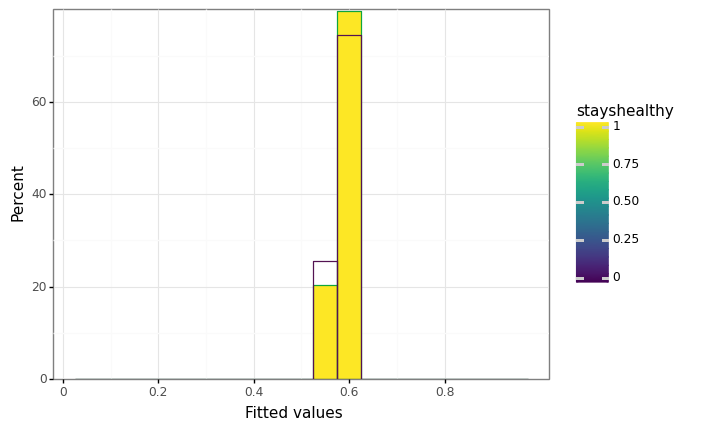

<ggplot: (334831830)>

In [91]:
g7a =(ggplot(data = share) 
 + geom_histogram(share[share['stayshealthy']==1],aes(x='pred_lpmbase',fill = 'stayshealthy',y = 'stat(count/sum(count)))*100'),binwidth = 0.05, alpha=1, color=color[1])
 + geom_histogram(share[share['stayshealthy']==0],aes(x='pred_lpmbase',fill = 'stayshealthy',y = 'stat(count/sum(count)))*100'),binwidth = 0.05, alpha=0, color=color[2])
 + ylab("Percent") 
 + xlab("Fitted values") 
 + scale_x_continuous(expand=[0.01,0.01] ,limits = [0,1], breaks = seq(0,1,0.2)) 
 + scale_y_continuous(expand=[0.00,0.00] ,limits = [0,80], breaks = seq(0,80,20)) 
 + theme_bw() 
)
g7a

/usr/local/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 2 rows containing non-finite values.
/usr/local/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
/usr/local/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


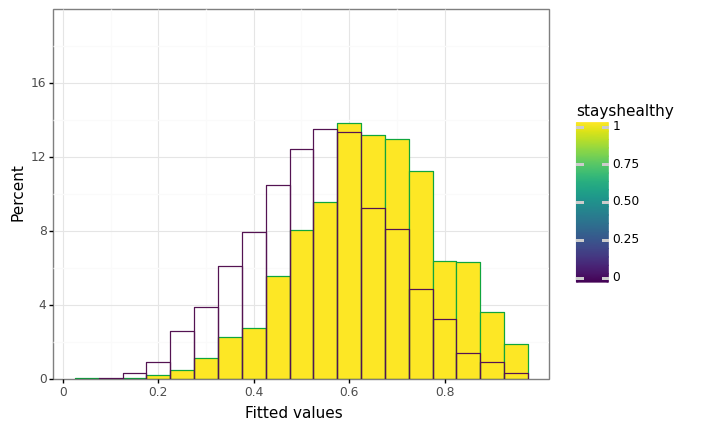

<ggplot: (332633351)>

In [92]:
g7b =(ggplot(data = share) 
 + geom_histogram(share[share['stayshealthy']==1],aes(x='pred_lpm',fill = 'stayshealthy',y = 'stat(count/sum(count)))*100'),binwidth = 0.05, alpha=1, color=color[1])
 + geom_histogram(share[share['stayshealthy']==0],aes(x='pred_lpm',fill = 'stayshealthy',y = 'stat(count/sum(count)))*100'),binwidth = 0.05, alpha=0, color=color[2])
 + ylab("Percent") 
 + xlab("Fitted values") 
 + scale_x_continuous(expand=[0.01,0.01] ,limits = [0,1], breaks = seq(0,1,0.2)) 
 + scale_y_continuous(expand=[0.00,0.00] ,limits = [0,20], breaks = seq(0,20,4)) 
 + theme_bw() 
)
g7b

In [93]:
share.groupby('stayshealthy')['pred_lpmbase','pred_lpm','pred_logit','pred_probit'].mean()

<ipython-input-93-963d61082742>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,pred_lpmbase,pred_lpm,pred_logit,pred_probit
stayshealthy,,,,
0,0.602536,0.542627,0.541993,0.542372
1,0.606108,0.645272,0.645687,0.645549


In [94]:
share.groupby('stayshealthy')['pred_lpmbase','pred_lpm','pred_logit','pred_probit'].median()

<ipython-input-94-66423b17d32d>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,pred_lpmbase,pred_lpm,pred_logit,pred_probit
stayshealthy,,,,
0,0.62039,0.543480,0.543988,0.544583
1,0.62039,0.646661,0.654917,0.653014


In [95]:
##Create calibration plot

In [96]:
## Part 7

In [97]:
df = share[['pred_lpmbase','pred_lpm','pred_logit','pred_probit']].copy()

In [98]:
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if df.iloc[i,j]>0.5:
            df.iloc[i,j]=1
        else:
            df.iloc[i,j]=0
            

In [99]:
pd.crosstab(df.iloc[:,0],share['stayshealthy'],normalize='all')

stayshealthy,0,1
pred_lpmbase,,
1.0,0.395304,0.604696


In [100]:
for j in range(df.shape[1]):
    print(pd.crosstab(df.iloc[:,j],share['stayshealthy'],normalize='all'))
    print(pd.crosstab(df.iloc[:,j],share['stayshealthy'],normalize='columns'))

stayshealthy         0         1
pred_lpmbase                    
1.0           0.395304  0.604696
stayshealthy    0    1
pred_lpmbase          
1.0           1.0  1.0
stayshealthy         0         1
pred_lpm                        
0.0           0.149244  0.100675
1.0           0.246060  0.504021
stayshealthy         0         1
pred_lpm                        
0.0           0.377543  0.166489
1.0           0.622457  0.833511
stayshealthy         0         1
pred_logit                      
0.0           0.153104  0.101962
1.0           0.242200  0.502734
stayshealthy         0         1
pred_logit                      
0.0           0.387307  0.168617
1.0           0.612693  0.831383
stayshealthy         0         1
pred_probit                     
0.0           0.150209  0.101640
1.0           0.245095  0.503056
stayshealthy         0         1
pred_probit                     
0.0           0.379984  0.168085
1.0           0.620016  0.831915


In [102]:
#Part 8

In [103]:
share = pd.read_csv(os.path.join(data_out,"ch11_share.csv"))

In [104]:
share['country'] = share['country'].astype('category')

In [105]:
y,X = dmatrices("stayshealthy ~ smoking + ever_smoked + female + age + lspline(eduyears,[8,18]) + \
                 income10 + lspline(bmi,[35]) + exerc + country",share)

In [106]:
logit = sm.Logit(y,X).fit()

Optimization terminated successfully.
         Current function value: 0.617166
         Iterations 5


In [107]:
logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                          Logit   Df Residuals:                     3084
Method:                           MLE   Df Model:                           24
Date:                Thu, 15 Apr 2021   Pseudo R-squ.:                 0.08031
Time:                        10:32:06   Log-Likelihood:                -1918.8
converged:                       True   LL-Null:                       -2086.3
Covariance Type:            nonrobust   LLR p-value:                 1.329e-56
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.2781      0.885      2.573      0.010       0.543       4.013
country[T.12]                    -0.9828      0.330     -2.978      0.003      -1.630      -0.336
country[T.13]                    -0.1972      0.276     -0.714      0.475      -0.739       0.344
country[T.15]                    -0.6560      0.194     -3.382      0.001      -1.036      -0.276
country[T.16]                    -1.1196      0.185     -6.051      0.000      -1.482      -0.757
country[T.17]                    -0.7850      0.169     -4.640      0.000      -1.116      -0.453
country[T.18]                     0.4358      0.181      2.411      0.016       0.082       0.790
country[T.20]                     0.0679      0.159      0.426      0.670      -0.244       0.380
country[T.23]                    -0.5734      0.157     -3.650      0.000      -0.881      -0.265
country[T.28]                    -0.7552      0.176     -4.297      0.000      -1.100      -0.411
country[T.29]                    -1.4707      0.395     -3.719      0.000      -2.246      -0.696
country[T.33]                    -1.5783      0.301     -5.243      0.000      -2.168      -0.988
country[T.34]                    -0.9203      0.205     -4.482      0.000      -1.323      -0.518
country[T.35]                    -1.3535      0.211     -6.416      0.000      -1.767      -0.940
smoking                          -0.2840      0.109     -2.601      0.009      -0.498      -0.070
ever_smoked                       0.0782      0.092      0.849      0.396      -0.102       0.259
female                            0.1608      0.082      1.964      0.050       0.000       0.321
age                              -0.0123      0.014     -0.859      0.391      -0.040       0.016
lspline(eduyears, [8, 18])[0]    -0.0030      0.033     -0.090      0.928      -0.068       0.062
lspline(eduyears, [8, 18])[1]     0.0791      0.016      5.022      0.000       0.048       0.110
lspline(eduyears, [8, 18])[2]    -0.0457      0.055     -0.825      0.410      -0.154       0.063
income10                          0.0356      0.015      2.452      0.014       0.007       0.064
lspline(bmi, [35])[0]            -0.0575      0.011     -5.033      0.000      -0.080      -0.035
lspline(bmi, [35])[1]             0.0311      0.071      0.439      0.661      -0.108       0.170
exerc                             0.2548      0.079      3.229      0.001       0.100       0.410
=================================================================================================
"""

In [108]:
share['bx_logit'] = np.asarray(X).dot(logit.params)

In [109]:
share['illustr_logit'] = logistic.cdf(share['bx_logit'])

In [110]:
probit = sm.Probit(y,X).fit()

Optimization terminated successfully.
         Current function value: 0.617255
         Iterations 5


In [111]:
probit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                         Probit   Df Residuals:                     3084
Method:                           MLE   Df Model:                           24
Date:                Thu, 15 Apr 2021   Pseudo R-squ.:                 0.08018
Time:                        10:32:37   Log-Likelihood:                -1919.0
converged:                       True   LL-Null:                       -2086.3
Covariance Type:            nonrobust   LLR p-value:                 1.722e-56
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.4340      0.540      2.656      0.008       0.376       2.492
country[T.12]                    -0.5952      0.203     -2.926      0.003      -0.994      -0.197
country[T.13]                    -0.1128      0.166     -0.678      0.498      -0.439       0.213
country[T.15]                    -0.4007      0.119     -3.368      0.001      -0.634      -0.167
country[T.16]                    -0.6872      0.113     -6.082      0.000      -0.909      -0.466
country[T.17]                    -0.4761      0.103     -4.615      0.000      -0.678      -0.274
country[T.18]                     0.2573      0.105      2.440      0.015       0.051       0.464
country[T.20]                     0.0425      0.096      0.445      0.657      -0.145       0.230
country[T.23]                    -0.3450      0.095     -3.622      0.000      -0.532      -0.158
country[T.28]                    -0.4579      0.108     -4.252      0.000      -0.669      -0.247
country[T.29]                    -0.8784      0.235     -3.740      0.000      -1.339      -0.418
country[T.33]                    -0.9741      0.182     -5.359      0.000      -1.330      -0.618
country[T.34]                    -0.5592      0.126     -4.426      0.000      -0.807      -0.312
country[T.35]                    -0.8280      0.129     -6.407      0.000      -1.081      -0.575
smoking                          -0.1705      0.066     -2.568      0.010      -0.301      -0.040
ever_smoked                       0.0443      0.056      0.793      0.428      -0.065       0.154
female                            0.0973      0.050      1.953      0.051      -0.000       0.195
age                              -0.0083      0.009     -0.955      0.339      -0.025       0.009
lspline(eduyears, [8, 18])[0]    -0.0021      0.020     -0.102      0.918      -0.041       0.037
lspline(eduyears, [8, 18])[1]     0.0478      0.010      5.015      0.000       0.029       0.066
lspline(eduyears, [8, 18])[2]    -0.0286      0.033     -0.864      0.388      -0.093       0.036
income10                          0.0216      0.009      2.446      0.014       0.004       0.039
lspline(bmi, [35])[0]            -0.0346      0.007     -5.002      0.000      -0.048      -0.021
lspline(bmi, [35])[1]             0.0169      0.044      0.388      0.698      -0.069       0.102
exerc                             0.1510      0.048      3.148      0.002       0.057       0.245
=================================================================================================
"""

In [112]:
share['bx_probit'] = np.asarray(X).dot(probit.params)

In [113]:
share['illustr_probit'] = norm.cdf(share['bx_probit'])

In [114]:
share_plot = pd.melt(share[['bx_logit','illustr_logit','illustr_probit']],id_vars=['bx_logit'],value_vars=['illustr_logit','illustr_probit'])

In [115]:
share_plot.head()

,bx_logit,variable,value
0,0.659329,illustr_logit,0.659110
1,0.862263,illustr_logit,0.703133
2,1.116094,illustr_logit,0.753263
3,0.902998,illustr_logit,0.711565
4,0.404842,illustr_logit,0.599850


In [116]:
share_plot['variable']=share_plot['variable'].replace('illustr_logit', 'Logit').replace('illustr_probit', 'Probit')

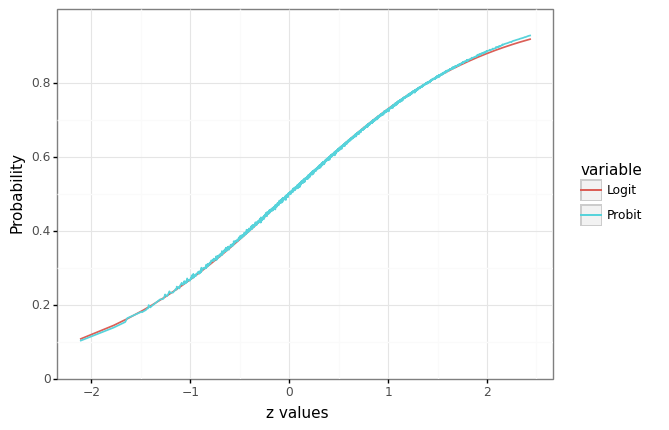

<ggplot: (335034230)>

In [117]:
g4 =(ggplot(data = share_plot) 
 + geom_line(aes(x='bx_logit',y ='value',color='variable'),size=0.7)
 + ylab("Probability") 
 + xlab("z values") 
 + scale_y_continuous(expand=[0.00,0.00] ,limits = [0,1], breaks = seq(0,1,0.2)) 
 + theme_bw() 
)
g4